# Modeling: Publication-Level Split + MRR Evaluation

This notebook provides a clean interface for training and evaluating citation matching models.

## Overview

The notebook uses utility functions from `src/modeling_utils.py` and `src/visualization.py` to:
- Load pre-split data (train/val/test) generated by `match_and_fe.ipynb`
- Train RandomForest model with Optuna hyperparameter tuning
- Evaluate model performance on test set
- Compute MRR@5 (Mean Reciprocal Rank at 5) for ranking evaluation
- Generate predictions and update `pred.json` files for all papers
- Visualize model performance, feature importance, and evaluation metrics

## Features

- **Data Sampling**: Optional sampling for large training datasets (keeps all positives)
- **Model Evaluation**: Classification metrics and MRR@5 calculation
- **Feature Importance**: Analysis of feature contributions
- **Prediction Generation**: Updates `pred.json` files with top 5 candidates
- **Visualization Dashboard**: Comprehensive performance visualizations


## Configuration

Configure the modeling pipeline by setting the following parameters:

- **`ENABLE_SAMPLING`**: Whether to sample training data if too large
- **`SAMPLE_SIZE`**: Maximum number of training samples (keeps all positives)
- **`RANDOM_STATE`**: Random seed for reproducibility

**Note**: This notebook requires pre-split data from `match_and_fe.ipynb`. Make sure to run the split step first.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setup paths and import utilities
import sys
from pathlib import Path

# Add src to path for imports
ROOT = Path("/content/drive/MyDrive/23120334").resolve()
sys.path.insert(0, str(ROOT / "src"))

import pandas as pd
import numpy as np
import joblib

# Import utility functions
from modeling_utils import (
    setup_paths, load_split_data, prepare_data_for_training,
    train_model, evaluate_model, compute_mrr_scores,
    update_pred_json_files, get_feature_importance, FEATURE_COLS
)

# Import visualization functions
from visualization import (
    plot_confusion_matrix, plot_classification_report,
    plot_feature_importance, plot_mrr_distribution,
    visualize_model_performance
)

# Setup paths
paths = setup_paths()
ROOT = paths['root']
SPLIT_DIR = paths['split_dir']
MODEL_DIR = paths['model_dir']
MODEL_PATH = paths['model_path']
PROCESSED_DIR = paths['processed_dir']

# Display configuration
print("=" * 60)
print("CONFIGURATION")
print("=" * 60)

def display_path(path_value: Path) -> str:
    try:
        relative = Path(path_value).resolve().relative_to(ROOT)
        return str(Path(ROOT.name) / relative)
    except ValueError:
        return str(path_value)

print(f"Root directory:        {ROOT.name}")
print(f"Split directory:       {display_path(SPLIT_DIR)}")
print(f"Model directory:       {display_path(MODEL_DIR)}")
print(f"Model path:            {display_path(MODEL_PATH)}")
print(f"Processed directory:   {display_path(PROCESSED_DIR)}")
print("=" * 60)


CONFIGURATION
Root directory:        23120334
Split directory:       23120334\split
Model directory:       23120334\models
Model path:            23120334\models\citation_matcher_rf.pkl
Processed directory:   23120334\23120334


## Load Data

Load pre-split data from train/val/test JSONL files generated by `match_and_fe.ipynb`.


In [ ]:
# Load pre-split data (generated by match_and_fe.ipynb) from ../split
train_df, val_df, test_df = load_split_data(SPLIT_DIR)

df = pd.concat([train_df, val_df, test_df], ignore_index=True)
print("Loaded rows:", len(df))
print(df.head())
print({"train": len(train_df), "val": len(val_df), "test": len(test_df)})


Loaded rows: 494577
     paper_id                    bib_key     cand_id  score  levenshtein  \
0  2408-02487           xu2023licensecom  2308-05942    1.0          0.0   
1  2408-02487  karamolegkou2023copyright  2310-13771    1.0          0.0   
2  2408-02487    zhang2021counterfactual  2112-12938    1.0          0.0   
3  2408-02487     carlini2022quantifying  2202-07646    1.0          0.0   
4  2408-02487     dong2024generalization  2402-15938    1.0          0.0   

   jaccard  token_overlap  token_overlap_ratio  char_ngram_3  char_ngram_4  \
0      1.0              7                  1.0           0.0           0.0   
1      1.0              5                  1.0           0.0           0.0   
2      1.0              5                  1.0           0.0           0.0   
3      1.0              6                  1.0           0.0           0.0   
4      1.0             10                  1.0           0.0           0.0   

   char_ngram_5  author_overlap  author_lastname_match

## Data Split Summary

Display summary statistics of the data split.


In [ ]:
# Split already provided by files; just report counts
print("Split sizes (papers):", df.groupby('partition')['paper_id'].nunique().to_dict())
print(df['partition'].value_counts())


Split sizes (papers): {'test': 2, 'train': 528, 'val': 2}
partition
train    489406
test       2597
val        2574
Name: count, dtype: int64


## Feature Configuration

Display the feature columns used for training.


In [ ]:
# Feature columns are defined in modeling_utils
print("Feature columns:", FEATURE_COLS)
print("Rows train/val/test:", len(train_df), len(val_df), len(test_df))


Feature columns: ['levenshtein', 'year_match', 'year_diff', 'source_year', 'cand_year', 'token_overlap', 'token_overlap_ratio', 'char_ngram_3', 'char_ngram_4', 'char_ngram_5', 'author_overlap', 'author_lastname_match']
Rows train/val/test: 489406 2574 2597


In [ ]:
# --- Feature selection: ablation without overlap/char n-gram ---
NO_OVERLAP_FEATURES = {
    "token_overlap",
    "token_overlap_ratio",
    "char_ngram_3",
    "char_ngram_4",
    "char_ngram_5",
    "num_overlap"
}

USE_NO_OVERLAP = True
FEATURE_COLS_ACTIVE = [c for c in FEATURE_COLS if c not in NO_OVERLAP_FEATURES] if USE_NO_OVERLAP else FEATURE_COLS

print("Using features:", FEATURE_COLS_ACTIVE)
print("Excluded features:", sorted(NO_OVERLAP_FEATURES) if USE_NO_OVERLAP else [])



Using features: ['levenshtein', 'year_match', 'year_diff', 'source_year', 'cand_year', 'author_overlap', 'author_lastname_match']
Excluded features: ['char_ngram_3', 'char_ngram_4', 'char_ngram_5', 'token_overlap', 'token_overlap_ratio']


## Model Training

Train RandomForest model with Optuna hyperparameter tuning. The training process includes:
- Data sampling for large datasets (optional, keeps all positive samples)
- Optuna search with validation F1-score
- Model evaluation on validation set


In [ ]:
# --- TRAIN MODEL WITH OPTUNA ---
# OPTIMIZATIONS APPLIED:
# 1. Data sampling for large datasets (keeps all positives)
# 2. Optuna search with validation F1-score
# 3. Optimized n_jobs settings

print("Setting up Hyperparameter Tuning (Optuna)...")

# Prepare data for training
ENABLE_SAMPLING = False
SAMPLE_SIZE = 500000

X_train, y_train, X_val, y_val, X_test, y_test, _ = prepare_data_for_training(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    feature_cols=FEATURE_COLS_ACTIVE,
    enable_sampling=ENABLE_SAMPLING,
    sample_size=SAMPLE_SIZE
)

print(f"Combined Data Shape: ({len(X_train) + len(X_val)}, {X_train.shape[1]})")
print("Using explicit Validation set for Optuna tuning.")

try:
    import optuna
except ModuleNotFoundError:
    import sys
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "optuna"])
    import optuna

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report

RANDOM_STATE = 42
N_TRIALS = 30


def objective(trial: optuna.Trial) -> float:
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 400, step=50),
        "max_depth": trial.suggest_int("max_depth", 5, 30, step=5),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced", "balanced_subsample"]),
        "random_state": RANDOM_STATE,
        "n_jobs": -1,
    }

    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, pos_label=1)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=False)

print("\n" + "=" * 60)
print("OPTUNA TUNING COMPLETE")
print("=" * 60)
print(f"Best Params: {study.best_params}")
print(f"Best Val F1: {study.best_value:.4f}")
print("=" * 60)

# Train final model on train + val using best params
best_params = dict(study.best_params)
best_params.update({"random_state": RANDOM_STATE, "n_jobs": -1})
rf = RandomForestClassifier(**best_params)

X_train_full = np.concatenate([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])
rf.fit(X_train_full, y_train_full)

# Save model
joblib.dump(rf, MODEL_PATH)
print(f"\nBest model saved to: {MODEL_PATH}")

# Validation predictions
val_pred = rf.predict(X_val)
print("\nVal report:")
print(classification_report(y_val, val_pred, labels=[0, 1]))


Setting up Hyperparameter Tuning (Optuna)...
Combined Data Shape: (491980, 7)
Using explicit Validation set for Optuna tuning.


[I 2026-01-18 17:52:37,044] A new study created in memory with name: no-name-87c2e8a9-d3d5-4aa2-8772-959a6f22f60f
[I 2026-01-18 17:52:47,725] Trial 0 finished with value: 0.7057291666666666 and parameters: {'n_estimators': 250, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7057291666666666.
[I 2026-01-18 17:53:07,140] Trial 1 finished with value: 0.7001254705144291 and parameters: {'n_estimators': 250, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.7057291666666666.
[I 2026-01-18 17:53:14,722] Trial 2 finished with value: 0.7001254705144291 and parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.7057291666666666.
[I 2026-01-18 17:53:27,450] 


OPTUNA TUNING COMPLETE
Best Params: {'n_estimators': 350, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced_subsample'}
Best Val F1: 0.7072

Best model saved to: C:\Users\huynh\Downloads\23120334\models\citation_matcher_rf.pkl

Val report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88      2000
           1       0.57      1.00      0.73       574

    accuracy                           0.83      2574
   macro avg       0.79      0.89      0.80      2574
weighted avg       0.90      0.83      0.85      2574



## Model Evaluation

Evaluate the trained model on the test set, including:
- Classification metrics (precision, recall, F1-score)
- Confusion matrix visualization
- MRR@5 calculation for ranking evaluation


EVALUATION SUMMARY (TEST SET)
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.64      0.77      2000
           1       0.44      0.98      0.61       597

    accuracy                           0.71      2597
   macro avg       0.72      0.81      0.69      2597
weighted avg       0.86      0.71      0.74      2597



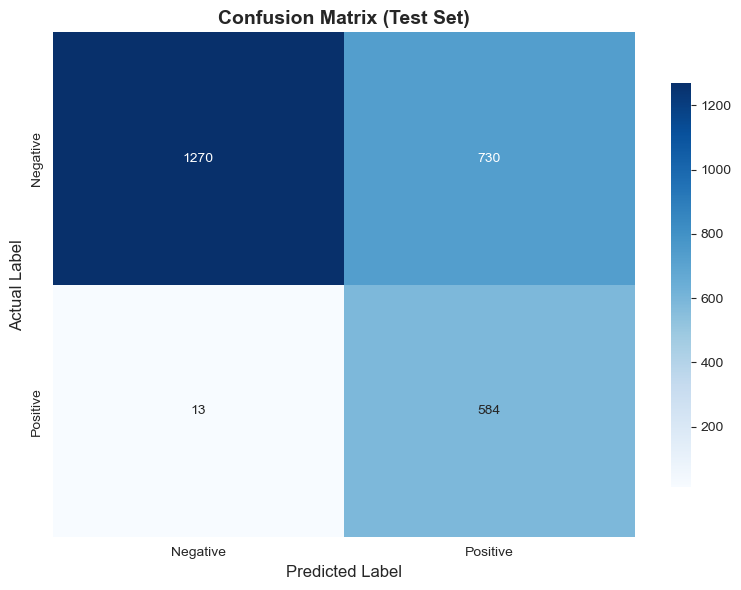

Test queries evaluated: 114
MRR@5:                 0.8940
Result:                Excellent (>0.8)


In [ ]:
# --- EVALUATION ---

# Evaluate model on test set
eval_results = evaluate_model(rf, X_test, y_test, X_val, y_val)

print("=" * 60)
print("EVALUATION SUMMARY (TEST SET)")
print("=" * 60)

# Classification report
from sklearn.metrics import classification_report
print("Classification report:")
print(classification_report(y_test, eval_results['test']['y_pred']))

# Visualize confusion matrix
plot_confusion_matrix(
    eval_results['test']['confusion_matrix'],
    title="Confusion Matrix (Test Set)"
)

# Calculate MRR for test set
mrr_scores, n_queries = compute_mrr_scores(test_df, rf, FEATURE_COLS_ACTIVE)
final_mrr = np.mean(mrr_scores) if mrr_scores else 0.0

if final_mrr > 0.8:
    status = "Excellent (>0.8)"
elif final_mrr > 0.5:
    status = "Acceptable (>0.5)"
else:
    status = "Needs Improvement (<0.5)"

print(f"Test queries evaluated: {n_queries}")
print(f"MRR@5:                 {final_mrr:.4f}")
print(f"Result:                {status}")
print("=" * 60)


## Feature Importance Analysis

Analyze and visualize the importance of each feature in the trained model.


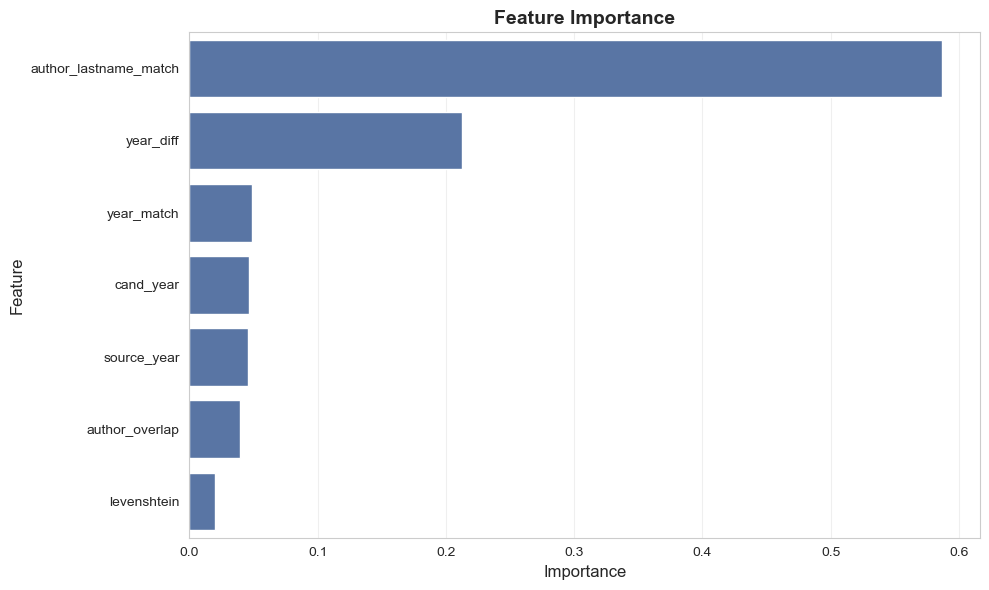

                 Feature  Importance
6  author_lastname_match    0.587068
2              year_diff    0.212649
1             year_match    0.049093
4              cand_year    0.046082
3            source_year    0.045931
5         author_overlap    0.039091
0            levenshtein    0.020087


In [ ]:
# --- Feature Importance Analysis ---
feature_imp_df = get_feature_importance(rf, FEATURE_COLS_ACTIVE)

# Visualize feature importance
plot_feature_importance(feature_imp_df, title="Feature Importance")

print(feature_imp_df)


## Generate Predictions

Update `pred.json` files for all papers with top 5 predictions for each bibliography key.


In [ ]:
# --- Update pred.json with top 5 predictions ---
stats = update_pred_json_files(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    model=rf,
    feature_cols=FEATURE_COLS_ACTIVE,
    processed_dir=PROCESSED_DIR,
    show_progress=True
)

# Final statistics
final_mrr = np.mean(stats['mrr_scores']) if stats['mrr_scores'] else 0.0

print("\n" + "="*50)
print("THỐNG KÊ")
print("="*50)
print(f"Tổng số papers:        {stats['total_papers']}")
print(f"Papers đã cập nhật:     {stats['updated_papers']}")
print(f"Tổng số bib_keys:       {stats['total_bib_keys']}")
print(f"Test queries:           {stats['test_queries']}")
print(f"MRR@5:                  {final_mrr:.4f}")
print(f"Kết quả:                {'Excellent' if final_mrr > 0.7 else 'Acceptable' if final_mrr > 0.5 else 'Needs Improvement'}")
print("="*50)


Updating pred.json:   0%|          | 0/532 [00:00<?, ?it/s]


THỐNG KÊ
Tổng số papers:        532
Papers đã cập nhật:     532
Tổng số bib_keys:       39533
Test queries:           114
MRR@5:                  0.8911
Kết quả:                Excellent
